In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [2]:
class DF( enum.Enum ):
    _10SEC = 0
    _10SEC_AVG = 1
    _30SEC = 2
    _30SEC_AVG = 3
    _1MIN = 4
    _1MIN_AVG = 5

# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', 'datasets' ]

df = {}
df[ DF._10SEC ] = pd.read_csv( os.path.join( *path, 'ds-residential-10sec.csv' ) , index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._10SEC_AVG ] = pd.read_csv( os.path.join( *path, 'ds-residential-10sec-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._30SEC ] = pd.read_csv( os.path.join( *path, 'ds-residential-30sec-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._30SEC_AVG ] = pd.read_csv( os.path.join( *path, 'ds-residential-30sec-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._1MIN ] = pd.read_csv( os.path.join( *path, 'ds-residential-1min-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._1MIN_AVG ] = pd.read_csv( os.path.join( *path, 'ds-residential-1min-avg.csv' ), index_col = 'date', parse_dates = [ 'date' ] )

## Data splitting, standarization and balancing

In [3]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._10SEC: 1,
    DF._10SEC_AVG: 1,
    DF._30SEC: 1,
    DF._30SEC_AVG: 1,
    DF._1MIN: 1,
    DF._1MIN_AVG: 1
}

for k, d in df.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._10SEC Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._10SEC Counter({'M': 16364, 'E': 16348, 'H': 16327, 'L': 16325})

Before balancing: DF._10SEC_AVG Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._10SEC_AVG Counter({'M': 16345, 'E': 16334, 'L': 16325, 'H': 16323})

Before balancing: DF._30SEC Counter({'L': 5450, 'E': 1345, 'M': 956, 'H': 188})
After balancing: DF._30SEC Counter({'L': 5450, 'E': 5449, 'H': 5448, 'M': 5444})

Before balancing: DF._30SEC_AVG Counter({'L': 5450, 'E': 1345, 'M': 956, 'H': 188})
After balancing: DF._30SEC_AVG Counter({'L': 5450, 'E': 5449, 'H': 5448, 'M': 5444})

Before balancing: DF._1MIN Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN Counter({'H': 2732, 'L': 2730, 'E': 2730, 'M': 2721})

Before balancing: DF._1MIN_AVG Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN_AVG Counter({'H': 2732, 'L': 2730, 'E': 2730, 'M': 2721})



## Training

In [4]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from ml.classification import *

params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 6, 8, 10, 11, 12 ]
} ]

grids = { 
    DF._10SEC: None,
    DF._10SEC_AVG: None,
    DF._30SEC: None,
    DF._30SEC_AVG: None,
    DF._1MIN: None,
    DF._1MIN_AVG: None
}

labels = [ 'E', 'H', 'L', 'M' ]

### Regular

Dataset  DF._1MIN_AVG 4
Best params:  {'criterion': 'entropy', 'max_depth': 12}
Training Accuracy 0.9882711277417966
Test Accuracy:  0.9567404426559356
Test ROCauc (OvR): 0.9408131518289437

Detailed Classification Report
              precision    recall  f1-score   support

           E       0.95      0.94      0.94       183
           H       0.95      0.78      0.86        23
           L       0.97      0.98      0.97       673
           M       0.90      0.90      0.90       115

    accuracy                           0.96       994
   macro avg       0.94      0.90      0.92       994
weighted avg       0.96      0.96      0.96       994


CPU times: user 19.5 s, sys: 37.3 ms, total: 19.5 s
Wall time: 19.5 s


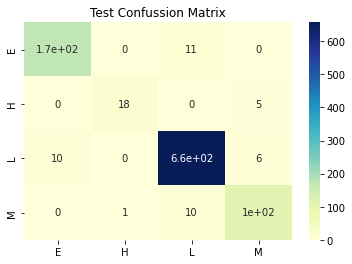

In [5]:
%%time
for k, d in df.items():
    if( k != DF._10SEC and k != DF._10SEC_AVG and k != DF._30SEC and k != DF._30SEC_AVG and k != DF._1MIN ):
        print( 'Dataset ', k, len( d ) )
        grids[ k ] = train_and_test( 
                DecisionTreeClassifier(), params_dt, 
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], 
                plot_cmatrix = True, labels = labels )

# Evaluation

In [6]:
from ml.evaluation import *

## Learning Curves

In [ ]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in [ DF._10SEC, DF._10SEC_AVG, DF._30SEC, DF._30SEC_AVG, DF._1MIN ] ]
plot_learning_curves( temp, grids, 'DT' )